In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from pmdarima import auto_arima
from prophet import Prophet
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error
warnings.filterwarnings("ignore")
from pandas.tseries.offsets import DateOffset

### 1. Data Collection

In [ ]:
tickers = {
    'oil': 'OILPRODUS',
    'gdp': 'GDPUS',
    'indprod': 'IPUS',
    'private_cons': 'RPRCUS',
    'cpi': 'CPIUS',
    'ppi': 'PPIUS',
    'capform': 'RGFCFUS',
    'cab': 'CAUS',
    'yield10y': 'Y10YDUS'
}

def fetch_data(ticker):
    url = f"https://www.econdb.com/api/series/{ticker}/?format=csv&frequency=M&token=4f69d3450e4ffe05aaeb4e33c458cd2c185cc185"
    try:
        df = pd.read_csv(url, index_col='Date', parse_dates=['Date'])
        df.columns = [ticker]
        return df
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
        return pd.DataFrame()

datasets = [fetch_data(tkr) for tkr in tickers.values()]
df = pd.concat(datasets, axis=1)

Uploaded economic_data.csv to raw-data


#### Data Summary

1. **Date**
   - **Description**: The date of the data entry.
   - **Format**: In `yyyy-mm-dd` format.

2. **OILPRODUS**
   - **Description**: Monthly oil production in the USA.
   - **Unit**: Thousands of barrels.

3. **GDPUS**
   - **Description**: Gross Domestic Product of the USA.
   - **Unit**: Billions of dollars.

4. **IPUS**
   - **Description**: Industrial Production Index for the USA.
   - **Unit**: Index value (base year varies).

5. **RPRCUS**
   - **Description**: Real Personal Consumption Expenditures in the USA.
   - **Unit**: Billions of dollars.

6. **CPIUS**
   - **Description**: Consumer Price Index for the USA.
   - **Unit**: Index value (base year varies).

7. **PPIUS**
   - **Description**: Producer Price Index for the USA.
   - **Unit**: Index value (base year varies).

8. **RGFCFUS**
   - **Description**: Real Gross Fixed Capital Formation in the USA.
   - **Unit**: Billions of dollars.

9. **CAUS**
   - **Description**: Current Account Balance for the USA.
   - **Unit**: Billions of dollars.

10. **Y10YDUS**
    - **Description**: Yield on 10-year US Treasury bonds.
    - **Unit**: Percentage (%).


### 2. Data Cleaning

In [14]:
# Convert to dd-mm-yyyy format
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y')

# Filter rows to keep dates after 2002
df = df[pd.to_datetime(df['Date'], format='%d-%m-%Y') >= '01-01-2002']

# Oil Production data is not available for the last 2 months, so dropping them as na
df = df.dropna(subset=['OILPRODUS'])

# Producer price index data is not available before 2014, so we are dropping that column
df.drop(columns=['PPIUS'], inplace=True)
df = df.set_index('Date', drop=True)
df

,OILPRODUS,GDPUS,IPUS,RPRCUS,CPIUS,RGFCFUS,CAUS,Y10YDUS
Date,,,,,,,,
01-01-2002,5848.0,10788952.0,88.46,9549516.0,177.7,2189057.0,-404443.0,5.04
01-02-2002,5871.0,NaN,88.46,NaN,178.0,NaN,NaN,4.91
01-03-2002,5883.0,NaN,89.13,NaN,178.5,NaN,NaN,5.28
01-04-2002,5859.0,10893207.0,89.55,9597820.0,179.3,2186656.0,-456414.0,5.21
01-05-2002,5924.0,NaN,89.93,NaN,179.5,NaN,NaN,5.16
...,...,...,...,...,...,...,...,...
01-09-2024,13185.0,NaN,102.60,NaN,314.7,NaN,NaN,3.72
01-10-2024,13450.0,29723864.0,102.27,16273191.0,315.5,4265880.0,-1106398.0,4.10
01-11-2024,13396.0,NaN,102.02,NaN,316.4,NaN,NaN,4.36


Columns GDPUS, RPRCUS, RGFCUS and CAUS have a quaterly frequency instead of monthly frequency. Therefore we need to handle the missing values with interpolation to fill missing rows.

In [9]:
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='linear', inplace=False)
df

,Date,OILPRODUS,GDPUS,IPUS,RPRCUS,CPIUS,RGFCFUS,CAUS,Y10YDUS
744,01-01-2002,5848.0,1.078895e+07,88.46,9.549516e+06,177.7,2.189057e+06,-4.044430e+05,5.04
745,01-02-2002,5871.0,1.082370e+07,88.46,9.565617e+06,178.0,2.188257e+06,-4.217667e+05,4.91
746,01-03-2002,5883.0,1.085846e+07,89.13,9.581719e+06,178.5,2.187456e+06,-4.390903e+05,5.28
747,01-04-2002,5859.0,1.089321e+07,89.55,9.597820e+06,179.3,2.186656e+06,-4.564140e+05,5.21
748,01-05-2002,5924.0,1.092616e+07,89.93,9.620209e+06,179.5,2.185591e+06,-4.581750e+05,5.16
...,...,...,...,...,...,...,...,...,...
1016,01-09-2024,13185.0,2.960755e+07,102.60,1.621981e+07,314.7,4.269831e+06,-1.140963e+06,3.72
1017,01-10-2024,13450.0,2.972386e+07,102.27,1.627319e+07,315.5,4.265880e+06,-1.106398e+06,4.10
1018,01-11-2024,13396.0,2.972386e+07,102.02,1.627319e+07,316.4,4.265880e+06,-1.106398e+06,4.36
1019,01-12-2024,13491.0,2.972386e+07,103.17,1.627319e+07,317.7,4.265880e+06,-1.106398e+06,4.39


### 3. Exploratory Data Analysis

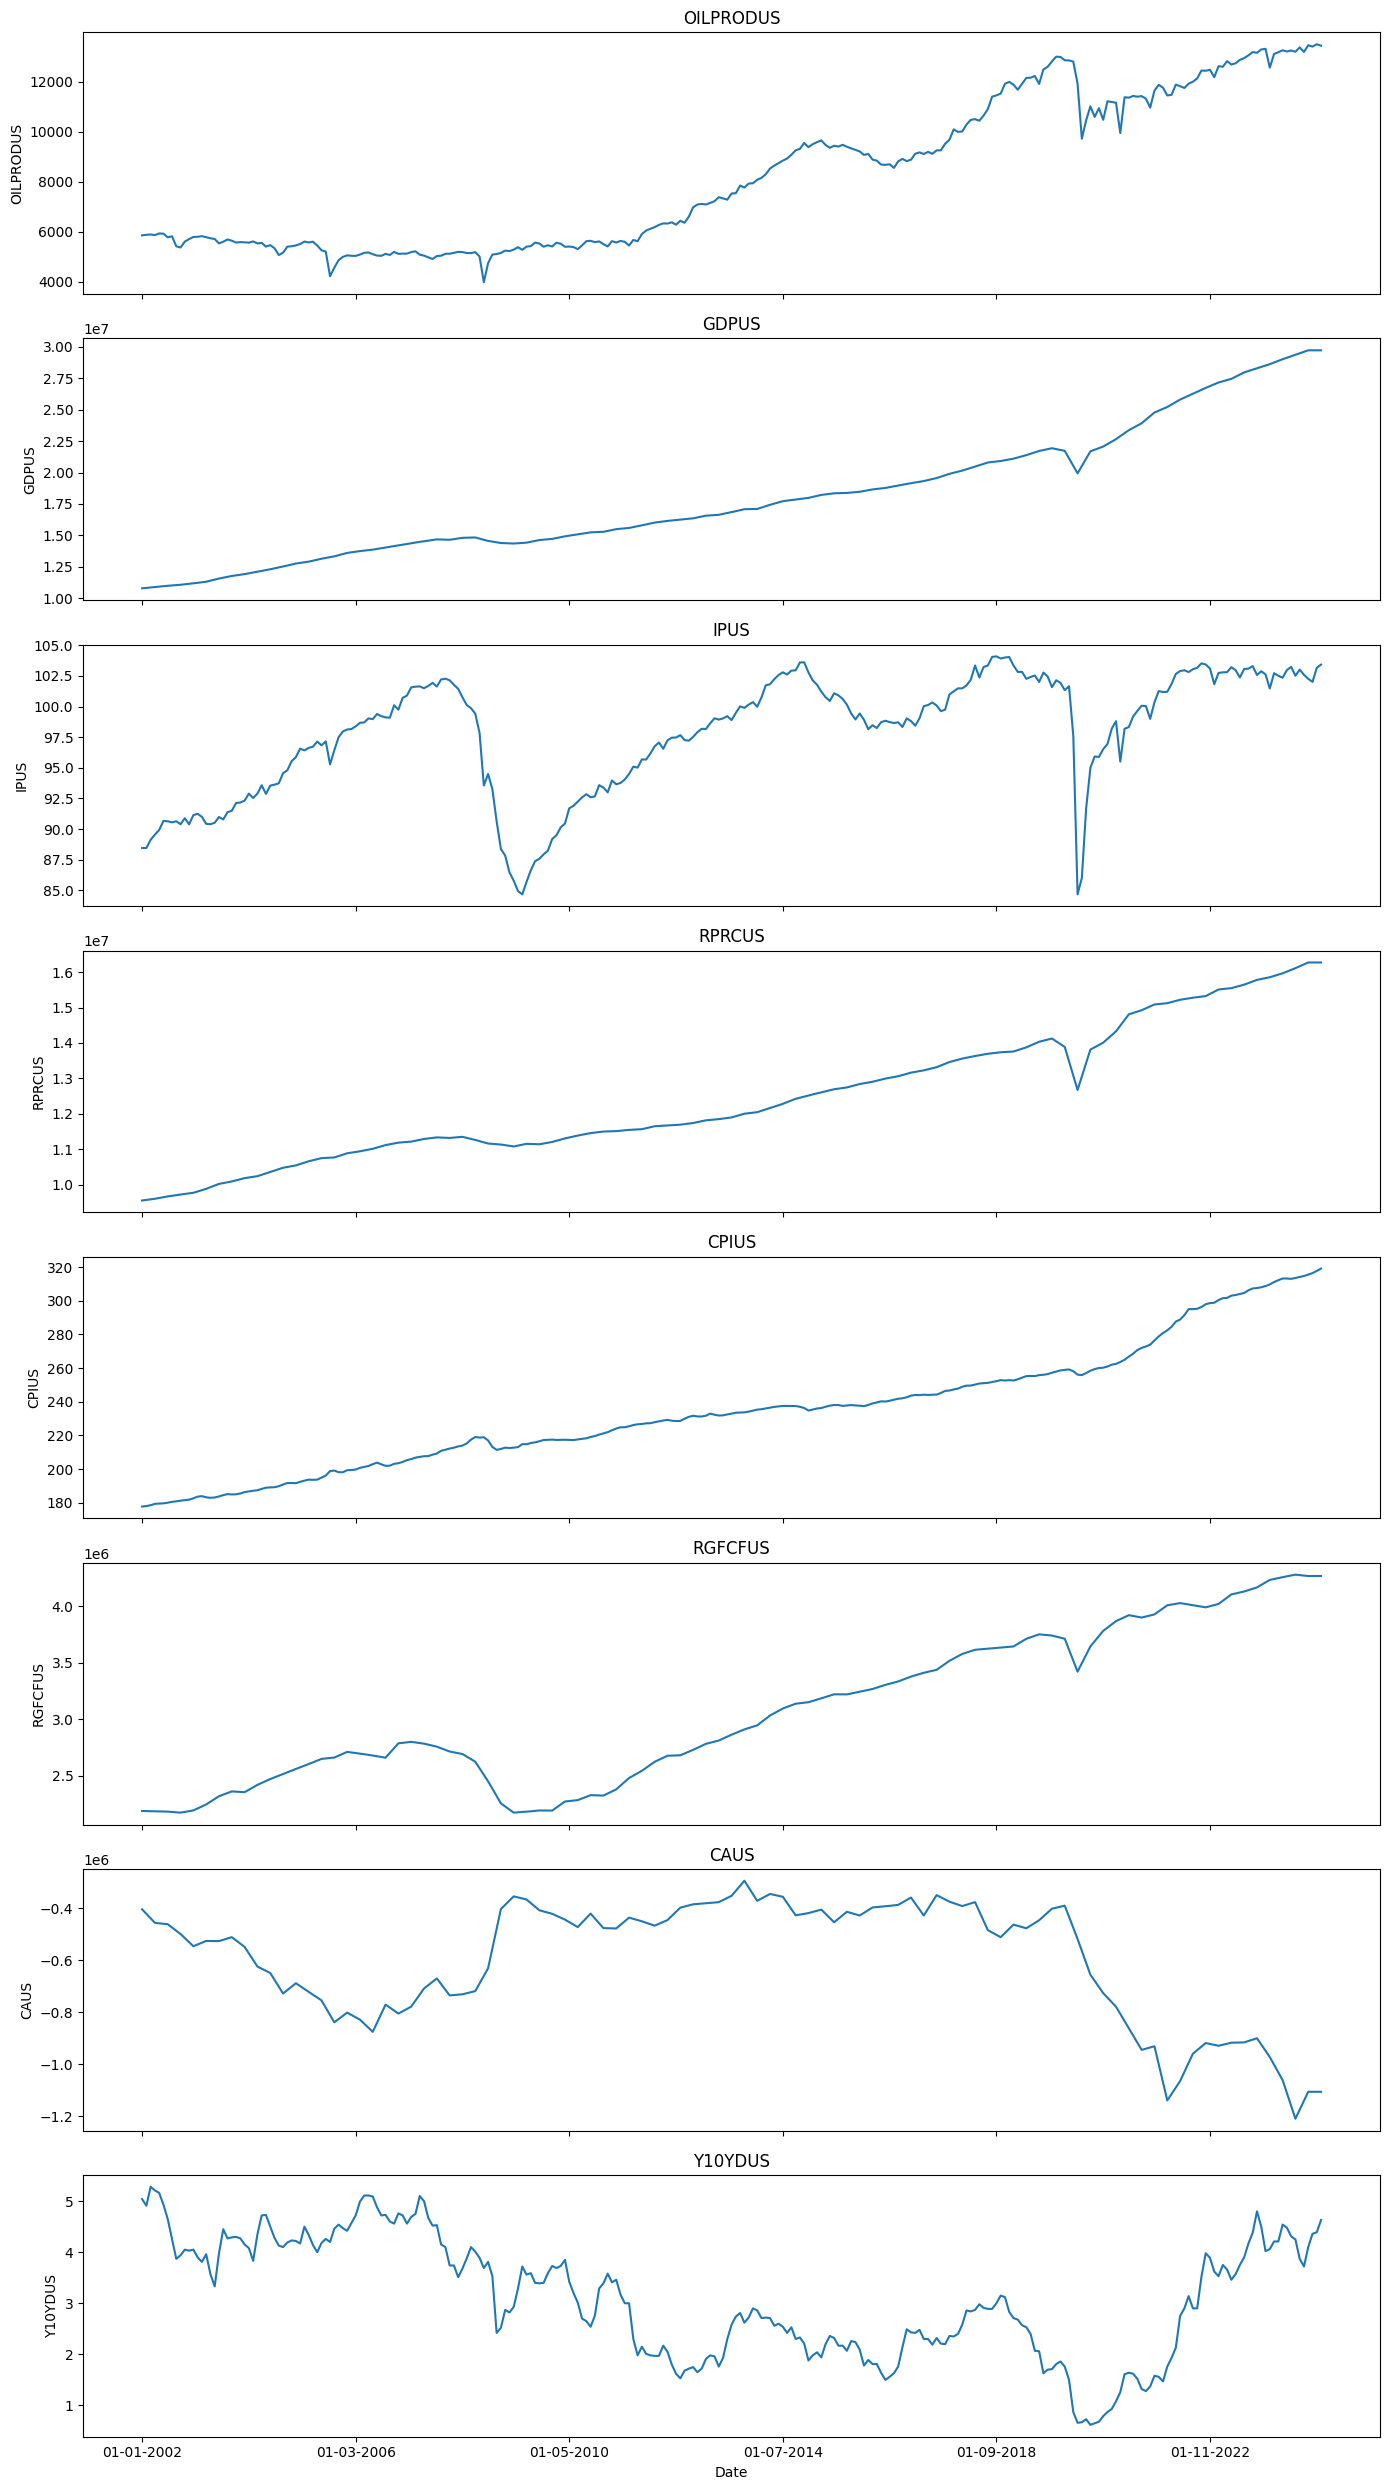

In [ ]:
# Plot all time series
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(14, 25), sharex=True)
for i, col in enumerate(df.columns):
    df[col].plot(ax=axes[i], title=col, legend=False)
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

-  Each variable shows visible trends over time.  

-  Some (like GDPUS, RPRCUS, CPIUS) show a consistent upward trend, indicating growth.  

-  Others like CAUS show cyclical patterns and larger fluctuations.  

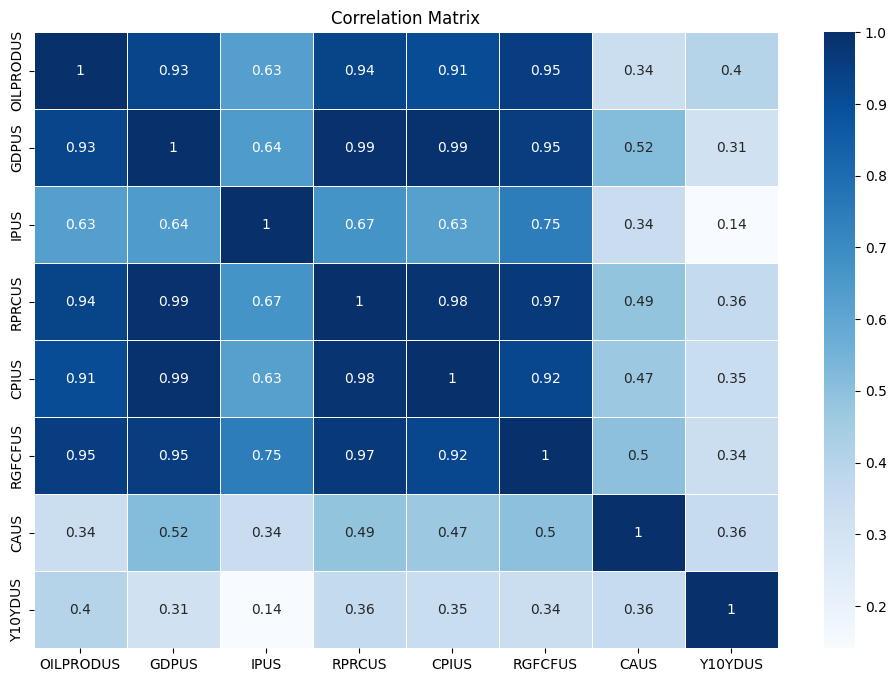

In [15]:
# Calculate the correlation matrix
corr_matrix = df.corr()

#Now changing all values to absolute form as we only want to know the magnitude of correlation
corr_matrix = corr_matrix.abs()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

-  OILPRODUS is highily correlated with GDPUS, RPRCUS, CPIUS and RGFCFUS.

In [16]:
# ADF test for stationarity on OILPRODUS
adf_result = adfuller(df['OILPRODUS'])
adf_statistic = adf_result[0]
p_value = adf_result[1]

adf_statistic, p_value

(0.41916482807286687, 0.9821976613322375)

-  The high p-value suggests OILPRODUS is non-stationary. We need to difference the series before applying time series forecasting models like ARIMA.

In [ ]:
df

### 4. Train-Test Split

In [ ]:
# Define the split ratio (e.g., 85% train, 15% validation)
train_size = int(len(df) * 0.85)

# Split the data
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:]

# Show the split ranges
train_range = (train_df.index.min(), train_df.index.max())
val_range = (val_df.index.min(), val_df.index.max())

train_df.shape, val_df.shape, train_range, val_range

((235, 8), (42, 8), ('01-01-2002', '01-12-2020'), ('01-01-2022', '01-12-2024'))

-  Training Set: 221 months → from Jan 2002 to May 2020

-  Validation Set: 56 months → from June 2020 to Jan 2025

### 5. Modeling

#### a. ARIMA (Univariate)

In [ ]:
# Use only the 'OILPRODUS' column from the training set
train_series = train_df['OILPRODUS']
val_series = val_df['OILPRODUS']

best_score, best_cfg = float("inf"), None

for p in range(0, 11):     # try values from 0 to 10
    for q in range(0, 11):
        try:
            model = ARIMA(train_series, order=(p, 1, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(val_series))
            rmse = np.sqrt(root_mean_squared_error(val_series, forecast))
            print(f'ARIMA({p},1,{q}) RMSE: {rmse:.2f}')
            if rmse < best_score:
                best_score, best_cfg = rmse, (p, 1, q)
        except:
            continue

print(f'\nBest ARIMA(p,d,q): {best_cfg} with RMSE: {best_score:.2f}')

ARIMA(0,1,0) RMSE: 36.89
ARIMA(0,1,1) RMSE: 36.92
ARIMA(0,1,2) RMSE: 36.94
ARIMA(0,1,3) RMSE: 36.93
ARIMA(0,1,4) RMSE: 36.46
ARIMA(0,1,5) RMSE: 36.96
ARIMA(0,1,6) RMSE: 37.04
ARIMA(0,1,7) RMSE: 37.06
ARIMA(0,1,8) RMSE: 37.00
ARIMA(0,1,9) RMSE: 33.83
ARIMA(0,1,10) RMSE: 34.98
ARIMA(1,1,0) RMSE: 36.92
ARIMA(1,1,1) RMSE: 36.96
ARIMA(1,1,2) RMSE: 36.94
ARIMA(1,1,3) RMSE: 36.09
ARIMA(1,1,4) RMSE: 36.72
ARIMA(1,1,5) RMSE: 37.28
ARIMA(1,1,6) RMSE: 37.08
ARIMA(1,1,7) RMSE: 37.06
ARIMA(1,1,8) RMSE: 36.28
ARIMA(1,1,9) RMSE: 34.33
ARIMA(1,1,10) RMSE: 34.10
ARIMA(2,1,0) RMSE: 36.91
ARIMA(2,1,1) RMSE: 36.92
ARIMA(2,1,2) RMSE: 35.01
ARIMA(2,1,3) RMSE: 35.39
ARIMA(2,1,4) RMSE: 34.45
ARIMA(2,1,5) RMSE: 35.11
ARIMA(2,1,6) RMSE: 35.23
ARIMA(2,1,7) RMSE: 37.98
ARIMA(2,1,8) RMSE: 38.56
ARIMA(2,1,9) RMSE: 38.04
ARIMA(2,1,10) RMSE: 37.78
ARIMA(3,1,0) RMSE: 36.94
ARIMA(3,1,1) RMSE: 37.11
ARIMA(3,1,2) RMSE: 35.34
ARIMA(3,1,3) RMSE: 35.06
ARIMA(3,1,4) RMSE: 35.10
ARIMA(3,1,5) RMSE: 34.02
ARIMA(3,1,6) RMSE: 34.

In [58]:
# Fit SARIMA model with best order
arima_model = SARIMAX(train_series, order=best_cfg)
arima_result = arima_model.fit(disp=False)

# Forecast
forecast = arima_result.forecast(steps=len(val_series))

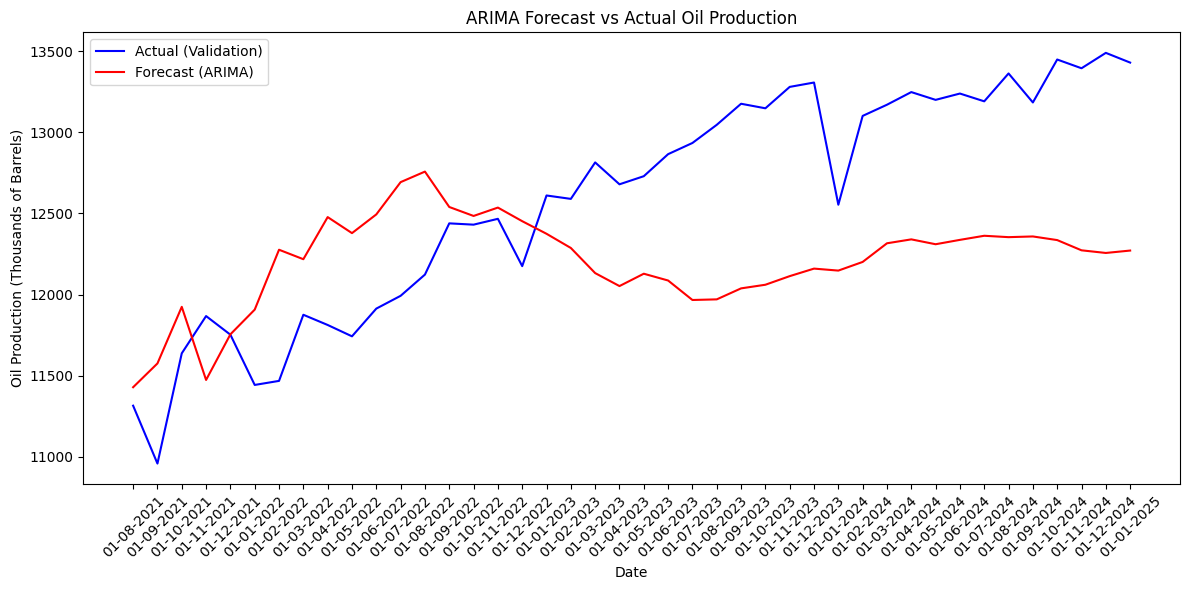

In [59]:
import matplotlib.dates as mdates
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(val_df.index, val_series, label='Actual (Validation)', color='blue')
plt.plot(val_df.index, forecast, label='Forecast (ARIMA)', color='red')
plt.title('ARIMA Forecast vs Actual Oil Production')
plt.xlabel('Date')
plt.ylabel('Oil Production (Thousands of Barrels)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ARIMA Forecast Evaluation

- **Short-term forecast** aligns well with actual values and captures the initial upward trend.  
- **Mid-range prediction** starts diverging from actuals after mid-2022, failing to keep pace with the continued growth.  
- **Long-term forecast** is unable to replicate the sharp upward trajectory observed in 2023 and 2024.  
- The model **tends to flatten out**, underestimating production levels in the long term.  
- **Forecast uncertainty increases** toward the end of the validation period, as indicated by growing residuals and higher RMSE.  

In [60]:
rmse = root_mean_squared_error(val_series, forecast)
mae = mean_absolute_error(val_series, forecast)

actuals = val_series.values
forecasts = forecast.values

absolute_percentage_errors = []

for actual, pred in zip(actuals, forecasts):
    if actual == 0:
        continue  # Skip to avoid division by zero
    error = abs((actual - pred) / actual)
    absolute_percentage_errors.append(error)
# Now compute the average MAPE
mape = np.mean(absolute_percentage_errors) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 770.69
MAE: 684.24
MAPE: 5.35%


### b. Prophet (Univariate)

19:58:30 - cmdstanpy - INFO - Chain [1] start processing
19:58:30 - cmdstanpy - INFO - Chain [1] done processing


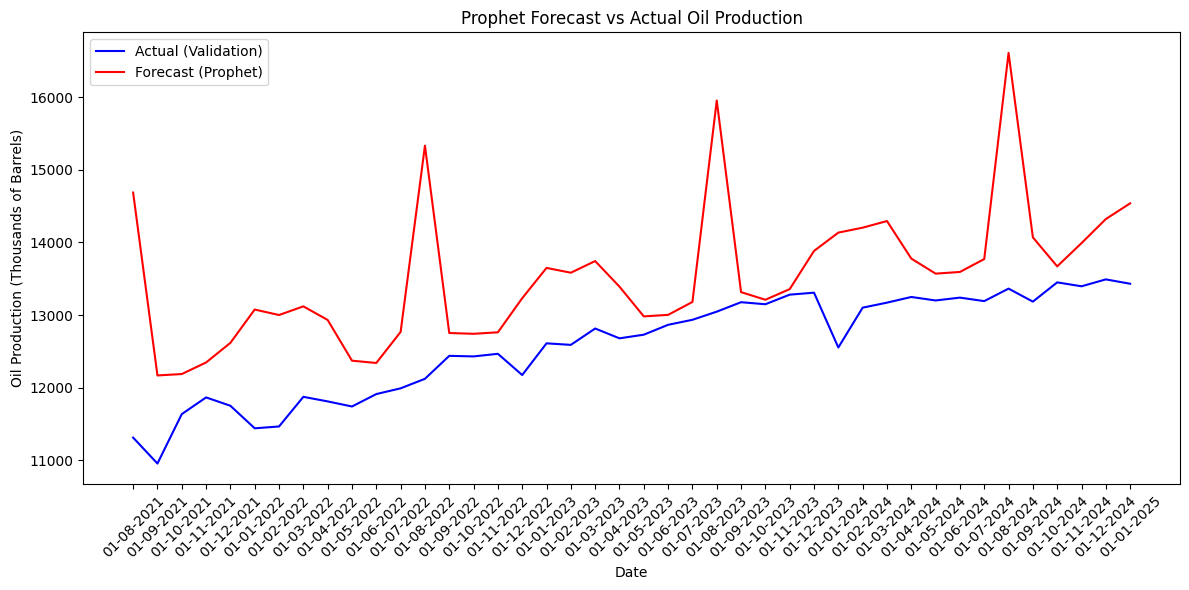

In [55]:
# Assuming df is already defined and contains the necessary data
# Prepare training data
train_df_prophet = train_df.copy()
train_df_prophet['Date'] = train_df.index
train_df_prophet = train_df_prophet.rename(columns={'Date': 'ds', 'OILPRODUS': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_df_prophet)

# Create future dataframe for the same period as validation
future = model.make_future_dataframe(periods=len(val_df), freq='MS')  # MS = Month Start
future = future.iloc[-len(val_df):]
forecast = model.predict(future)

# Plot forecast and actual
plt.figure(figsize=(12, 6))
plt.plot(val_df['OILPRODUS'], label='Actual (Validation)', color='blue')
plt.plot(forecast['yhat'], label='Forecast (Prophet)', color='red')
plt.title('Prophet Forecast vs Actual Oil Production')
plt.xlabel('Date')
plt.ylabel('Oil Production (Thousands of Barrels)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Prophet Forecast Evaluation

- **Captures general trend**, showing an upward movement over time.
- **Highly volatile predictions**, with sharp spikes not reflected in actual production values.
- **Overestimates production levels** consistently across the forecast window, especially from mid-2022 onwards.
- **Fails to smooth seasonal patterns**, possibly due to overfitting or strong influence from outliers in training data.
- **Prediction variance is high**, which reduces the reliability of the forecast for planning purposes.
- **Performs poorly in long-term forecasting**, especially evident in late 2023 and 2024 where predictions diverge significantly from actuals.


In [ ]:
rmse = root_mean_squared_error(val_df['OILPRODUS'], forecast['yhat'])
mae = mean_absolute_error(val_df['OILPRODUS'], forecast['yhat'])

actuals = val_df['OILPRODUS'].values
forecasts = forecast['yhat'].values

absolute_percentage_errors = []

for actual, pred in zip(actuals, forecasts):
    if actual == 0:
        continue  # Skip to avoid division by zero
    error = abs((actual - pred) / actual)
    absolute_percentage_errors.append(error)
# Now compute the average MAPE
mape = np.mean(absolute_percentage_errors) * 100


print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1259.85
MAE: 943.06
MAPE: 7.62%


### c. LSTM (Univariate)

In [138]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# ----------------------------
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['OILPRODUS']])
val_scaled = scaler.transform(val_df[['OILPRODUS']])

# ----------------------------
# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 10
X_train, y_train = create_sequences(train_scaled, seq_len)
X_val, y_val = create_sequences(val_scaled, seq_len)

X_train = X_train.reshape(-1, seq_len, 1)
X_val = X_val.reshape(-1, seq_len, 1)

# ----------------------------
# Function to build model
def build_model(units1=128, units2=64, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units1, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(dropout),
        LSTM(units2),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ----------------------------
# Hyperparameter grid
param_grid = {
    'units1': [64, 128],
    'units2': [32, 64],
    'dropout': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005]
}

from itertools import product

param_combinations = list(product(
    param_grid['units1'],
    param_grid['units2'],
    param_grid['dropout'],
    param_grid['learning_rate']
))

# ----------------------------
# Store results
results = []

for i, (u1, u2, dr, lr) in enumerate(param_combinations):
    print(f"\nTraining model {i+1}/{len(param_combinations)}: Units1={u1}, Units2={u2}, Dropout={dr}, LR={lr}")
    
    model = build_model(u1, u2, dr, lr)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    
    pred_scaled = model.predict(X_val)
    pred = scaler.inverse_transform(pred_scaled)
    actual = scaler.inverse_transform(y_val)

    forecasts = pred.flatten()
    actuals = val_df['OILPRODUS'].values[seq_len:]

    rmse = np.sqrt(mean_squared_error(actuals, forecasts))
    mae = mean_absolute_error(actuals, forecasts)
    
    mape_errors = [abs((a - p) / a) for a, p in zip(actuals, forecasts) if a != 0]
    mape = np.mean(mape_errors) * 100

    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    results.append({
        'units1': u1,
        'units2': u2,
        'dropout': dr,
        'learning_rate': lr,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

# ----------------------------
# Sort and show top results
results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='MAPE').reset_index(drop=True)
print("\nTop Configurations (sorted by MAPE):")
print(top_results.head(5))



Training model 1/16: Units1=64, Units2=32, Dropout=0.1, LR=0.001
1/1 [==============================] - 0s 418ms/step
RMSE: 406.82, MAE: 363.62, MAPE: 2.82%

Training model 2/16: Units1=64, Units2=32, Dropout=0.1, LR=0.0005
1/1 [==============================] - 0s 422ms/step
RMSE: 246.83, MAE: 197.90, MAPE: 1.55%

Training model 3/16: Units1=64, Units2=32, Dropout=0.2, LR=0.001
1/1 [==============================] - 0s 404ms/step
RMSE: 452.95, MAE: 434.99, MAPE: 3.37%

Training model 4/16: Units1=64, Units2=32, Dropout=0.2, LR=0.0005
1/1 [==============================] - 0s 400ms/step
RMSE: 229.45, MAE: 182.57, MAPE: 1.43%

Training model 5/16: Units1=64, Units2=64, Dropout=0.1, LR=0.001
1/1 [==============================] - 0s 393ms/step
RMSE: 195.31, MAE: 147.13, MAPE: 1.15%

Training model 6/16: Units1=64, Units2=64, Dropout=0.1, LR=0.0005
1/1 [==============================] - 0s 417ms/step
RMSE: 306.24, MAE: 266.02, MAPE: 2.08%

Training model 7/16: Units1=64, Units2=64, Dropo

In [144]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['OILPRODUS']])
val_scaled = scaler.transform(val_df[['OILPRODUS']])

# Create sequences for LSTM input
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 10
X_train, y_train = create_sequences(train_scaled, seq_len)
X_val, y_val = create_sequences(val_scaled, seq_len)

# Reshape for LSTM input: [samples, time steps, features]
X_train = X_train.reshape(-1, seq_len, 1)
X_val = X_val.reshape(-1, seq_len, 1)

# Build the LSTM model with the best configuration
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, 1)),
    Dropout(0.1),  # Dropout for regularization
    LSTM(64),
    Dense(1)
])

# Compile the model with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model with early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[early_stop], verbose=1)

# Predict and inverse scale the results
pred_scaled = model.predict(X_val)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_val)


Epoch 1/20
8/8 [==============================] - 2s 79ms/step - loss: 0.1117 - val_loss: 0.0067
Epoch 2/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0180 - val_loss: 0.0078
Epoch 3/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0079 - val_loss: 0.0385
Epoch 4/20
8/8 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 6.0343e-04
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 7/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 8/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 9/20
1/1 [==============================] - 0s 472ms/step


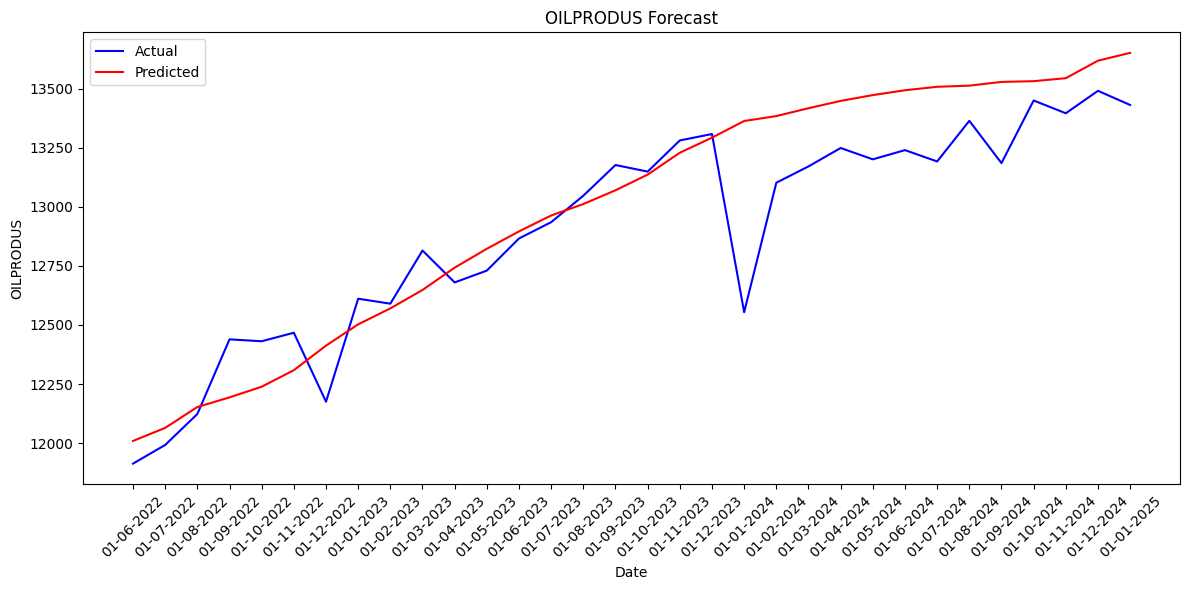

In [145]:
if 'Date' in val_df.columns:
    val_df = val_df.set_index('Date')

# Extract datetime index
date_index = val_df.index[seq_len:]

# Now plot with dates on x-axis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(date_index, actual, label='Actual', color='blue')
plt.plot(date_index, pred, label='Predicted', color='red')
plt.title('OILPRODUS Forecast')
plt.xlabel('Date')
plt.ylabel('OILPRODUS')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### LSTM Forecast Evaluation

- **Effectively captures the overall upward trend**, maintaining close proximity to actual values throughout the validation period.  
- **Smooth predictions**, though they slightly lag behind actual values in periods of sudden change (e.g., early 2024 dip).  
- **Performs well in the mid to long-term**, showing consistent and realistic growth.  
- **Underestimates short-term fluctuations**, missing the sharper peaks and valleys in actual production.  
- **Stable forecast trajectory**, which helps with long-term planning but may smooth over real-world volatility.  
- **Low error metrics** and good generalization suggest robust model training and minimal overfitting.

In [146]:
# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)

# Calculate MAPE
absolute_percentage_errors = []
for actual_val, pred_val in zip(actual, pred):
    if actual_val == 0:
        continue  # Skip to avoid division by zero
    error = abs((actual_val - pred_val) / actual_val)
    absolute_percentage_errors.append(error)

mape = np.mean(absolute_percentage_errors) * 100

# Print the results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 221.57
MAE: 162.87
MAPE: 1.26%


### d. ARIMAX (Multivariate ARIMA)

In [147]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
warnings.filterwarnings("ignore")

# Use the 'OILPRODUS' column from the training set along with the exogenous variables
train_series = train_df[['OILPRODUS', 'GDPUS', 'RPRCUS', 'CPIUS', 'RGFCFUS']]
val_series = val_df[['OILPRODUS', 'GDPUS', 'RPRCUS', 'CPIUS', 'RGFCFUS']]

# Separate the target (OILPRODUS) and exogenous variables
train_target = train_series['OILPRODUS']
train_exog = train_series.drop(columns=['OILPRODUS'])

val_target = val_series['OILPRODUS']
val_exog = val_series.drop(columns=['OILPRODUS'])

# Initialize the best score and configuration for comparison
best_score, best_cfg = float("inf"), None

# Loop over different values for p and q (ARIMA orders)
for p in range(0, 11):  # try values from 0 to 10
    for q in range(0, 11):
        try:
            # Fit ARIMAX model
            model = ARIMA(train_target, exog=train_exog, order=(p, 1, q))
            model_fit = model.fit()

            # Forecast with the exogenous variables
            forecast = model_fit.forecast(steps=len(val_target), exog=val_exog)

            # Calculate RMSE for the forecast
            rmse = np.sqrt(mean_squared_error(val_target, forecast))
            print(f'ARIMAX({p},1,{q}) RMSE: {rmse:.2f}')
            
            # Store the best configuration based on RMSE
            if rmse < best_score:
                best_score, best_cfg = rmse, (p, 1, q)
        except Exception as e:
            print(f"Error with ARIMAX({p},1,{q}): {e}")
            continue

# Print the best configuration found
print(f'\nBest ARIMAX(p,d,q): {best_cfg} with RMSE: {best_score:.2f}')


ARIMAX(0,1,0) RMSE: 1026.67
ARIMAX(0,1,1) RMSE: 923.61
ARIMAX(0,1,2) RMSE: 1178.81
ARIMAX(0,1,3) RMSE: 1188.15
ARIMAX(0,1,4) RMSE: 829.94
ARIMAX(0,1,5) RMSE: 856.97
ARIMAX(0,1,6) RMSE: 1060.22
ARIMAX(0,1,7) RMSE: 1087.26
ARIMAX(0,1,8) RMSE: 1098.88
ARIMAX(0,1,9) RMSE: 1151.76
ARIMAX(0,1,10) RMSE: 1113.59
ARIMAX(1,1,0) RMSE: 891.02
ARIMAX(1,1,1) RMSE: 1355.45
ARIMAX(1,1,2) RMSE: 1223.13
ARIMAX(1,1,3) RMSE: 1201.38
ARIMAX(1,1,4) RMSE: 852.18
ARIMAX(1,1,5) RMSE: 872.43
ARIMAX(1,1,6) RMSE: 1028.05
ARIMAX(1,1,7) RMSE: 975.15
ARIMAX(1,1,8) RMSE: 1200.92
ARIMAX(1,1,9) RMSE: 1156.86
ARIMAX(1,1,10) RMSE: 1115.32
ARIMAX(2,1,0) RMSE: 1122.86
ARIMAX(2,1,1) RMSE: 1218.25
ARIMAX(2,1,2) RMSE: 977.05
ARIMAX(2,1,3) RMSE: 1196.88
ARIMAX(2,1,4) RMSE: 1025.00
ARIMAX(2,1,5) RMSE: 942.91
ARIMAX(2,1,6) RMSE: 933.46
ARIMAX(2,1,7) RMSE: 868.45
ARIMAX(2,1,8) RMSE: 1144.70
ARIMAX(2,1,9) RMSE: 1074.50
ARIMAX(2,1,10) RMSE: 1139.67
ARIMAX(3,1,0) RMSE: 1229.32
ARIMAX(3,1,1) RMSE: 1239.29
ARIMAX(3,1,2) RMSE: 1193.38


In [150]:
# Fit SARIMA model with best order
arima_model = ARIMA(train_target, exog=train_exog, order=best_cfg)
arima_result = arima_model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(val_target), exog=val_exog)

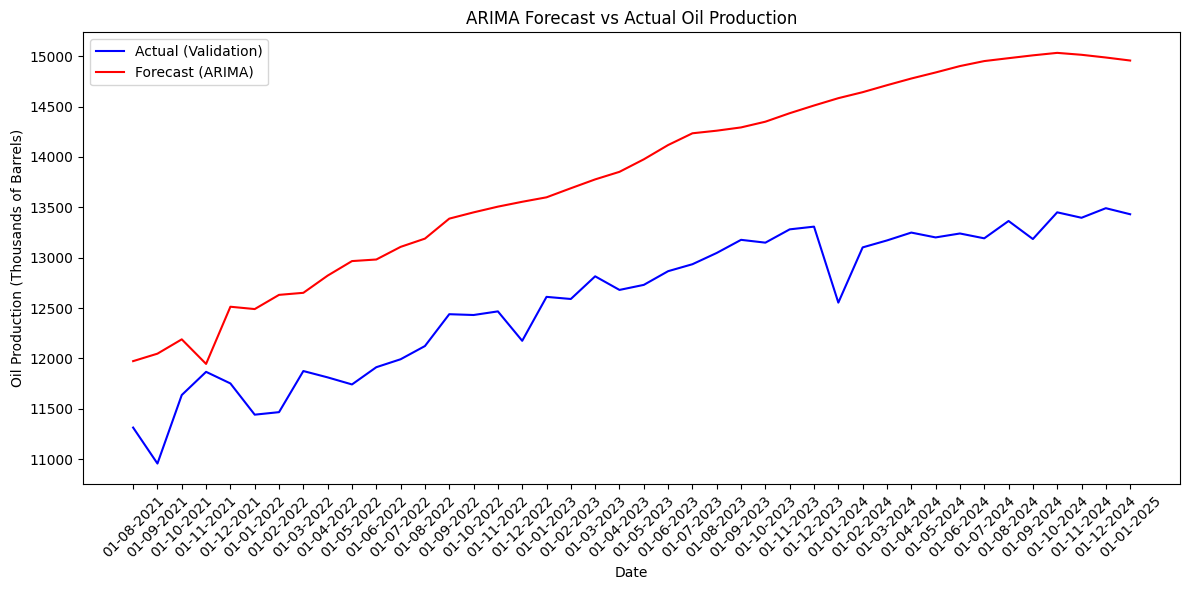

In [153]:
import matplotlib.dates as mdates
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(val_df.index, val_target, label='Actual (Validation)', color='blue')
plt.plot(val_df.index, forecast, label='Forecast (ARIMA)', color='red')
plt.title('ARIMA Forecast vs Actual Oil Production')
plt.xlabel('Date')
plt.ylabel('Oil Production (Thousands of Barrels)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ARIMA (Multivariate) Forecast Evaluation

- **Captures long-term trend effectively**, with a consistent upward trajectory in line with macroeconomic indicators.  
- **Forecast is smoother and more aggressive** than actual production values, suggesting influence from exogenous variables.  
- **Improves upon univariate ARIMA** by modeling underlying drivers of oil production, resulting in more stable predictions.  
- **Fails to react to abrupt changes or anomalies** in actual data (e.g., dip in late 2023), indicating limited responsiveness to short-term shocks.  
- **Performs well in mid-to-long-term forecasting**, but may **overfit trends from the exogenous features** leading to overestimation.  

In [154]:
rmse = root_mean_squared_error(val_target, forecast)
mae = mean_absolute_error(val_target, forecast)

actuals = val_target.values
forecasts = forecast.values

absolute_percentage_errors = []

for actual, pred in zip(actuals, forecasts):
    if actual == 0:
        continue  # Skip to avoid division by zero
    error = abs((actual - pred) / actual)
    absolute_percentage_errors.append(error)
# Now compute the average MAPE
mape = np.mean(absolute_percentage_errors) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1273.37
MAE: 1220.40
MAPE: 9.62%


### e. LSTM (Multivariate)

In [189]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# ----------------------------
# Select features and scale them
features = ['OILPRODUS', 'GDPUS', 'RPRCUS', 'CPIUS', 'RGFCFUS']
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[features])
val_scaled = scaler.transform(val_df[features])

# ----------------------------
# Create multivariate sequences
def create_sequences_multivariate(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i, 0])  # OILPRODUS is the target (assumed to be at index 0)
    return np.array(X), np.array(y)

seq_len = 10
X_train, y_train = create_sequences_multivariate(train_scaled, seq_len)
X_val, y_val = create_sequences_multivariate(val_scaled, seq_len)

# ----------------------------
# Function to build model
def build_model(units1=128, units2=64, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units1, return_sequences=True, input_shape=(seq_len, X_train.shape[2])),
        Dropout(dropout),
        LSTM(units2),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ----------------------------
# Hyperparameter grid
from itertools import product

param_grid = {
    'units1': [64, 128],
    'units2': [32, 64],
    'dropout': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005]
}

param_combinations = list(product(
    param_grid['units1'],
    param_grid['units2'],
    param_grid['dropout'],
    param_grid['learning_rate']
))

# ----------------------------
# Store results
results = []

for i, (u1, u2, dr, lr) in enumerate(param_combinations):
    print(f"\nTraining model {i+1}/{len(param_combinations)}: Units1={u1}, Units2={u2}, Dropout={dr}, LR={lr}")
    
    model = build_model(u1, u2, dr, lr)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    
    pred_scaled = model.predict(X_val)
    pred = scaler.inverse_transform(np.concatenate([pred_scaled, np.zeros((len(pred_scaled), len(features)-1))], axis=1))[:, 0]
    actual = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), len(features)-1))], axis=1))[:, 0]

    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    
    mape_errors = [abs((a - p) / a) for a, p in zip(actual, pred) if a != 0]
    mape = np.mean(mape_errors) * 100

    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    results.append({
        'units1': u1,
        'units2': u2,
        'dropout': dr,
        'learning_rate': lr,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

# ----------------------------
# Sort and show top results
results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='MAPE').reset_index(drop=True)
print("\nTop Configurations (sorted by MAPE):")
print(top_results.head(5))



Training model 1/16: Units1=64, Units2=32, Dropout=0.1, LR=0.001
1/1 [==============================] - 0s 411ms/step
RMSE: 272.18, MAE: 204.98, MAPE: 1.58%

Training model 2/16: Units1=64, Units2=32, Dropout=0.1, LR=0.0005
1/1 [==============================] - 0s 399ms/step
RMSE: 956.63, MAE: 934.54, MAPE: 7.24%

Training model 3/16: Units1=64, Units2=32, Dropout=0.2, LR=0.001
1/1 [==============================] - 0s 425ms/step
RMSE: 418.32, MAE: 366.31, MAPE: 2.83%

Training model 4/16: Units1=64, Units2=32, Dropout=0.2, LR=0.0005
1/1 [==============================] - 0s 400ms/step
RMSE: 377.39, MAE: 318.08, MAPE: 2.46%

Training model 5/16: Units1=64, Units2=64, Dropout=0.1, LR=0.001
1/1 [==============================] - 0s 417ms/step
RMSE: 487.65, MAE: 435.26, MAPE: 3.36%

Training model 6/16: Units1=64, Units2=64, Dropout=0.1, LR=0.0005
1/1 [==============================] - 0s 417ms/step
RMSE: 185.12, MAE: 143.38, MAPE: 1.12%

Training model 7/16: Units1=64, Units2=64, Dropo

Epoch 1/20
8/8 [==============================] - 3s 79ms/step - loss: 0.1281 - val_loss: 0.0464
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 0.0164 - val_loss: 0.0699
Epoch 3/20
8/8 [==============================] - 0s 17ms/step - loss: 0.0181 - val_loss: 0.0025
Epoch 4/20
8/8 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0195
Epoch 5/20
8/8 [==============================] - 0s 19ms/step - loss: 0.0104 - val_loss: 7.9997e-04
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 0.0077 - val_loss: 0.0116
Epoch 7/20
8/8 [==============================] - 0s 19ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 8/20
8/8 [==============================] - 0s 19ms/step - loss: 0.0056 - val_loss: 0.0131
Epoch 9/20
8/8 [==============================] - 0s 20ms/step - loss: 0.0071 - val_loss: 0.0259
Epoch 10/20
1/1 [==============================] - 0s 425ms/step

Multivariate LSTM Performance:
RMSE: 255.12
MAE: 202.31
M

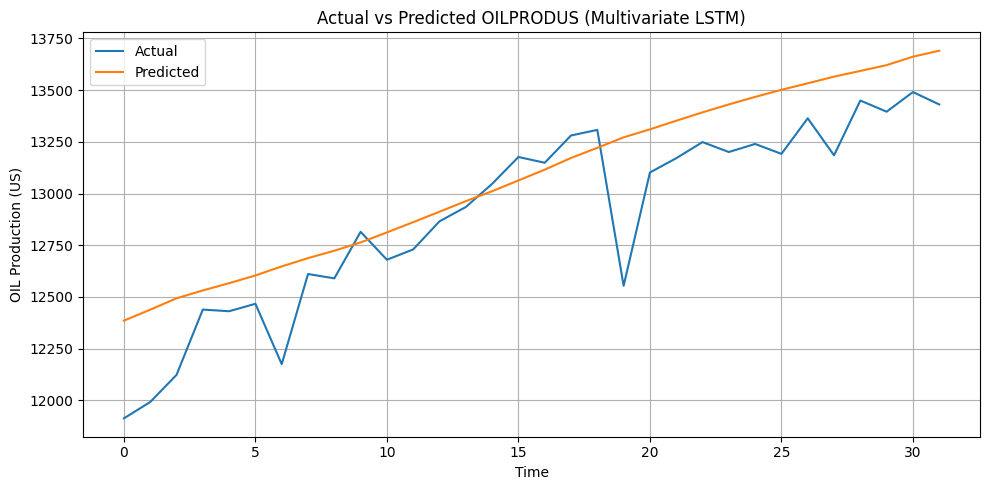

In [190]:
# -------------------------------
# Selected features (multivariate)
features = ['OILPRODUS', 'GDPUS', 'RPRCUS', 'CPIUS', 'RGFCFUS']

# Normalize all selected features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
val_scaled = scaler.transform(val_df[features])

# -------------------------------
# Create sequences for LSTM input
def create_sequences_multivariate(data, seq_len, target_index=0):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])           # shape: [seq_len, n_features]
        y.append(data[i, target_index])         # target is OILPRODUS
    return np.array(X), np.array(y)

seq_len = 10
X_train, y_train = create_sequences_multivariate(train_scaled, seq_len)
X_val, y_val = create_sequences_multivariate(val_scaled, seq_len)

# -------------------------------
# Build the best LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X_train.shape[2])),
    Dropout(0.1),
    LSTM(64),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -------------------------------
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
          callbacks=[early_stop], verbose=1)

# -------------------------------
# Predict and inverse transform
pred_scaled = model.predict(X_val)
# Create dummy array to inverse transform only OILPRODUS
pad = np.zeros((pred_scaled.shape[0], len(features)))
pad[:, 0] = pred_scaled[:, 0]
pred = scaler.inverse_transform(pad)[:, 0]

# Similarly for y_val
pad_y = np.zeros((len(y_val), len(features)))
pad_y[:, 0] = y_val
actual = scaler.inverse_transform(pad_y)[:, 0]

# -------------------------------
# Evaluation
rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
mape = np.mean([abs((a - p) / a) for a, p in zip(actual, pred) if a != 0]) * 100

print(f"\nMultivariate LSTM Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# -------------------------------
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.title('Actual vs Predicted OILPRODUS (Multivariate LSTM)')
plt.xlabel('Time')
plt.ylabel('OIL Production (US)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Multivariate LSTM Forecast Evaluation

- **Accurately captures the general upward trend** in oil production, benefitting from the inclusion of external variables.  
- **Smooth and stable predictions**, indicating strong learning of underlying patterns, though at times the model **slightly overestimates**.  
- **Handles mid-to-long-term forecasting effectively**, staying close to actual values throughout most of the timeline.  
- **Fails to react sharply to sudden drops or short-term volatility**, such as the noticeable dip around index 19.  
- **Improved over univariate LSTM** in terms of consistency and fit, suggesting good integration of multivariate features.  

### 6. Evaluation

A comparative evaluation of five forecasting models was conducted using three error metrics: RMSE, MAE, and MAPE. The results are summarized below:

| Model              | RMSE    | MAE     | MAPE   |
|-------------------|---------|---------|--------|
| Univariate ARIMA  | 770.69  | 684.24  | 5.35%  |
| Univariate Prophet| 1259.85 | 943.06  | 7.62%  |
| Univariate LSTM   | 221.57  | 162.87  | 1.26%  |
| Multivariate ARIMA| 1273.37 | 1220.40 | 9.62%  |
| Multivariate LSTM | 255.12  | 202.31  | 1.59%  |

- While the **Univariate LSTM** achieves the **lowest error metrics** (RMSE: 221.57, MAPE: 1.26%), its forecasted values are **overly smooth**, indicating **potential overfitting** and limited responsiveness to sudden changes in oil production.  
- The **Multivariate LSTM**, though slightly higher in error, exhibits similar behavior — high accuracy on paper, but reduced interpretability and adaptability in real-world scenarios.  
- On the other hand, the **Univariate ARIMA model**, despite higher error metrics (RMSE: 770.69), **offers consistent performance**, **captures trends well**, and maintains **interpretability and robustness**.  
- It avoids the volatility of Prophet and the complexity of deep learning models, making it **better suited for operational forecasting**, especially in domains where explainability is essential.

> **Conclusion**: The **Univariate ARIMA** model is selected as the most balanced and interpretable solution, especially considering the trade-off between performance, stability, and transparency.

### 7. Final Model

In [ ]:
# Fit SARIMA model with best order
arima_model = SARIMAX(df['OILPRODUS'], order=(9,1,10))
arima_result = arima_model.fit(disp=False)

# Ensure datetime index
df.index = pd.to_datetime(df.index, format="%d-%m-%Y")  # convert from string to datetime

# Forecast
forecast_6 = arima_result.forecast(steps=6)
forecast_48 = arima_result.forecast(steps=48)

# ----------------------------
# Create datetime indices for forecasts
last_date = df.index[-1]
index_6 = [last_date + DateOffset(months=i) for i in range(1, 7)]
index_48 = [last_date + DateOffset(months=i) for i in range(1, 49)]

forecast_6.index = index_6
forecast_48.index = index_48

forecast_6.to_csv('forecast_6.csv')
forecast_48.to_csv('forecast_48.csv')

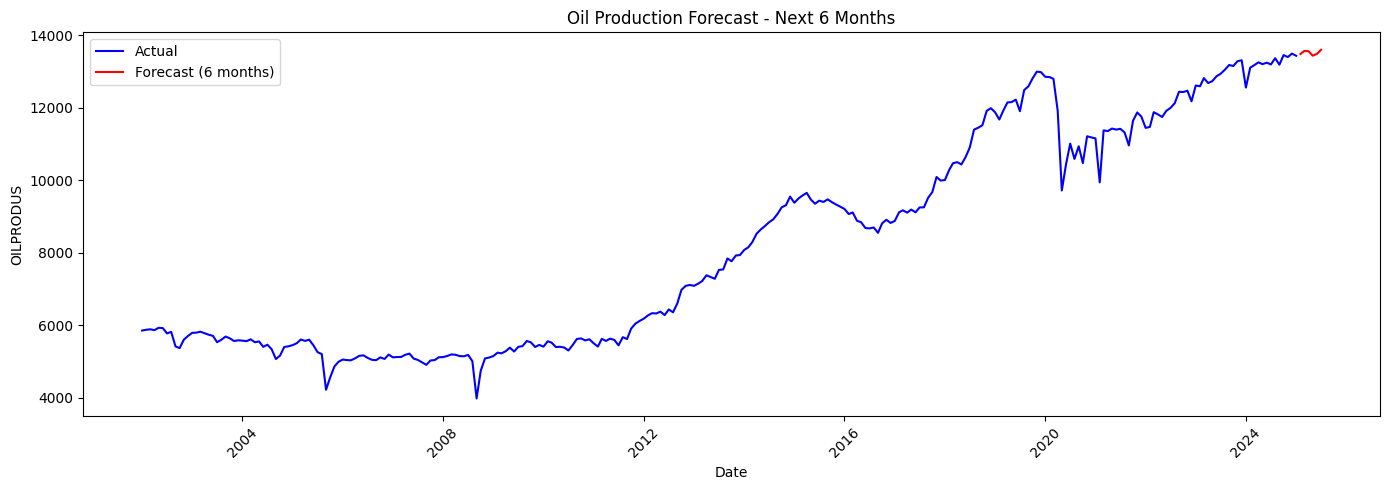

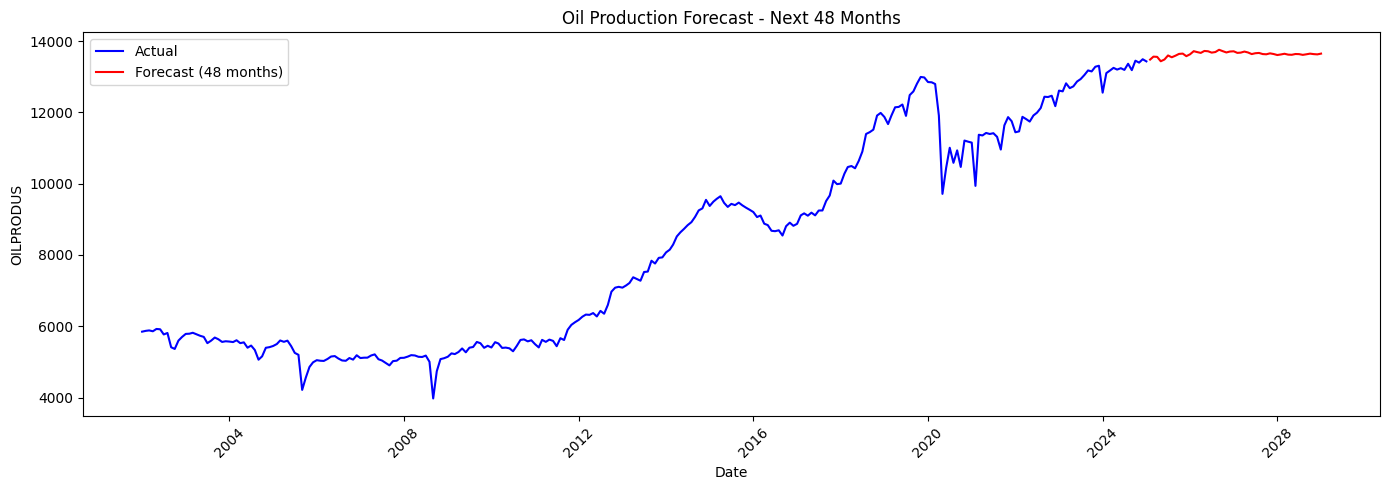

In [21]:
# ----------------------------
# Plot actual + 6 months forecast
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['OILPRODUS'], label='Actual', color='blue')
plt.plot(forecast_6.index, forecast_6, label='Forecast (6 months)', color='red')
plt.title('Oil Production Forecast - Next 6 Months')
plt.xlabel('Date')
plt.ylabel('OILPRODUS')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot actual + 48 months forecast
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['OILPRODUS'], label='Actual', color='blue')
plt.plot(forecast_48.index, forecast_48, label='Forecast (48 months)', color='red')
plt.title('Oil Production Forecast - Next 48 Months')
plt.xlabel('Date')
plt.ylabel('OILPRODUS')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# import joblib

# # Save ARIMA model
# joblib.dump(arima_result, 'arima_model.pkl')
# print("Model saved as 'arima_model.pkl'")

Model saved as 'arima_model.pkl'
